In [11]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth, geom_bar,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import matplotlib.pyplot as plt
import patchworklib as pw
import numpy as np
from llm_ran.benchmark.metrics import pass_at, pass_power

from llm_ran.benchmark.questions import TEST_CASES

import plotnine as pn
my_theme = lambda x, y: pn.theme_classic() + pn.theme(
    # axis_text_x=pn.element_text(rotation=15, hjust=1),
    panel_grid_major_y=pn.element_line(size=0.5, color="grey"),
    panel_border=pn.element_rect(size=1, color="black"),
    figure_size=(x, y)
)

In [12]:
QUESTIONS_META = {
    (test_case.scenario, question.id): question
    for test_case in TEST_CASES
    for question in test_case.questions
}

levels = ["Simple Fact Finding", "Complex Fact Finding", "Reasoning"]
evaluate_as = ["Numerical", "Multiple Choice"]

questions = pd.DataFrame([
    {
        "scenario": test_case.scenario or "base",
        "question": question.id,
        "question_type": levels[question.level],
        "question_base_format": evaluate_as[question.base_type],
    }
    for test_case in TEST_CASES
    for question in test_case.questions
]).set_index(["scenario", "question"])
# display(questions)

In [13]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"

mainline_models = [
    "qwen2.5:32b",
    # "qwen2.5-coder:32b",
    # "sky-t1:32b",
    # "qwq:32b",
]

df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[df['model'].isin(mainline_models)]
df = df.rename(columns={"chain": "agent"})
df = df.join(questions, on=["scenario", "question"])
df['question_type'] = pd.Categorical(df['question_type'], categories=levels, ordered=True)
df['model'] = pd.Categorical(df['model'], categories=mainline_models, ordered=True)
df['evaluate_as'] = pd.Categorical(df['evaluate_as'].apply(lambda x: evaluate_as[x]), categories=evaluate_as, ordered=True)

zero_to_na = ["total_tokens"]
for col in zero_to_na:
    df[col] = df[col].replace(0, np.nan)

df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'question_type',
       'question_base_format'],
      dtype='object')

In [14]:
group_by = ["question_type", "model", "agent"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]
agg1 = {
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "can_answer@10": ('can_answer', pass_at(10)),
    "can_answer^10": ('can_answer', pass_power(10)),
    "correct@5": ('correct', pass_at(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct^5": ('correct', pass_power(5)),
    "correct@10": ('correct', pass_at(10)),
    "correct^10": ('correct', pass_power(10)),
    "pass@5": ('pass', pass_at(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass^5": ('pass', pass_power(5)),
    "pass@10": ('pass', pass_at(10)),
    "pass^10": ('pass', pass_power(10)),
    "execution_time": ('execution_time', 'mean'),
    "total_tokens": ('total_tokens', 'mean'),
    "num_messages": ('num_messages', 'mean'),
}
groupby1 = ["scenario", "question"]

raw = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index()
# display(raw)
raw_pivoted = raw.melt(
    id_vars=group_by,
    value_vars=[*agg1.keys()],
    var_name="metric",
    value_name="value",
)
raw_grouped = raw_pivoted.groupby(
    group_by + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', lambda x: x.quantile(0.5)),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()
display(raw_grouped)

codegen = raw_grouped[raw_grouped['agent'] == "codegen"]

# resampled = df_type.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index().groupby(group_by)[list(agg1.keys())].agg('mean').join(
#     df_type.groupby(group_by)[list(agg.keys())].agg('mean'), on=group_by
# ).reset_index()
# # resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
# # display(resampled)
# pivoted = resampled.melt(
#     id_vars=group_by,
#     value_vars=[*agg.keys(), *agg1.keys()],
#     var_name="metric",
#     value_name="value",
# )
# display(pivoted)

,question_type,model,agent,metric,value_min,value_max,value,value_25,value_75
0,Simple Fact Finding,qwen2.5:32b,codegen,can_answer@1,0.0,1.0,0.750000,0.500000,0.925000
1,Simple Fact Finding,qwen2.5:32b,codegen,can_answer@10,0.0,1.0,1.000000,1.000000,1.000000
2,Simple Fact Finding,qwen2.5:32b,codegen,can_answer@5,0.0,1.0,1.000000,0.992960,1.000000
3,Simple Fact Finding,qwen2.5:32b,codegen,can_answer^10,0.0,1.0,0.067811,0.000977,0.511509
4,Simple Fact Finding,qwen2.5:32b,codegen,can_answer^5,0.0,1.0,0.247875,0.031250,0.692868
...,...,...,...,...,...,...,...,...,...
103,Reasoning,qwen2.5:32b,direct,pass@10,0.0,1.0,1.000000,1.000000,1.000000
104,Reasoning,qwen2.5:32b,direct,pass@5,0.0,1.0,1.000000,0.976190,1.000000
105,Reasoning,qwen2.5:32b,direct,pass^10,0.0,1.0,0.028248,0.000105,0.167700
106,Reasoning,qwen2.5:32b,direct,pass^5,0.0,1.0,0.168070,0.010240,0.393383


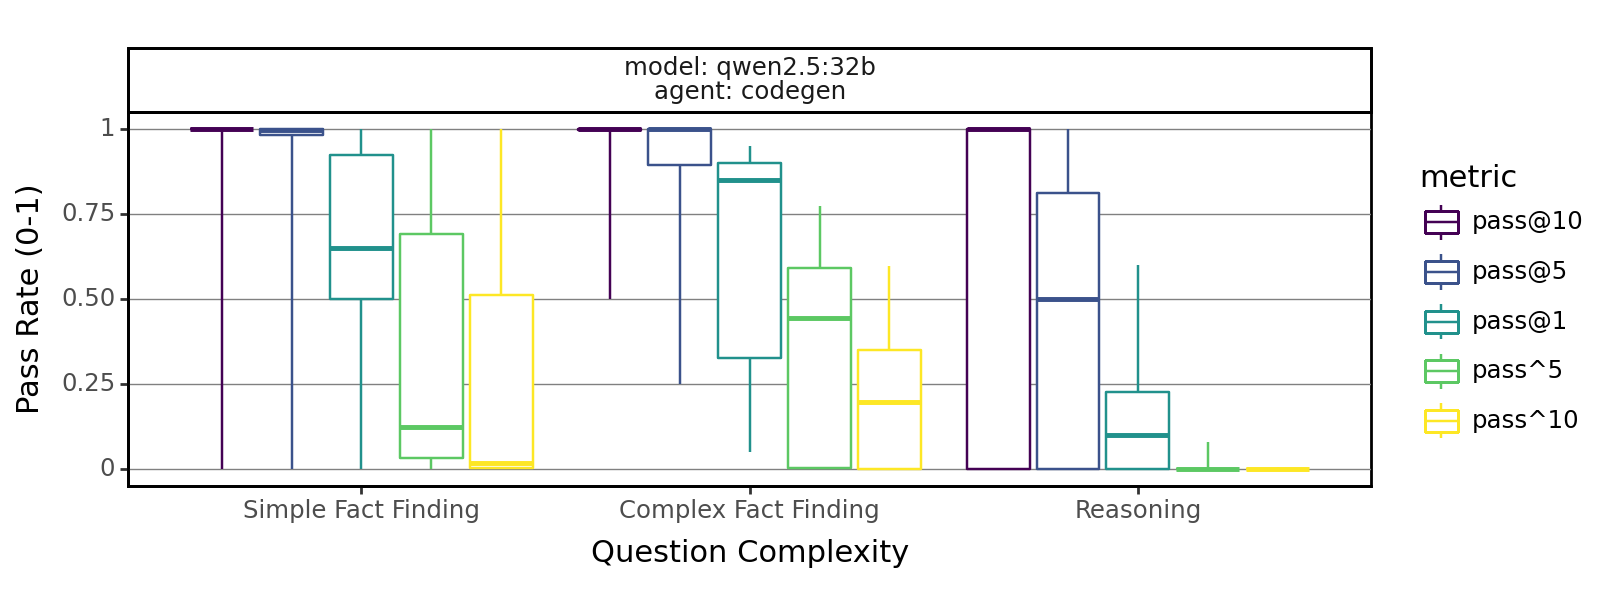

<Figure Size: (800 x 300)>

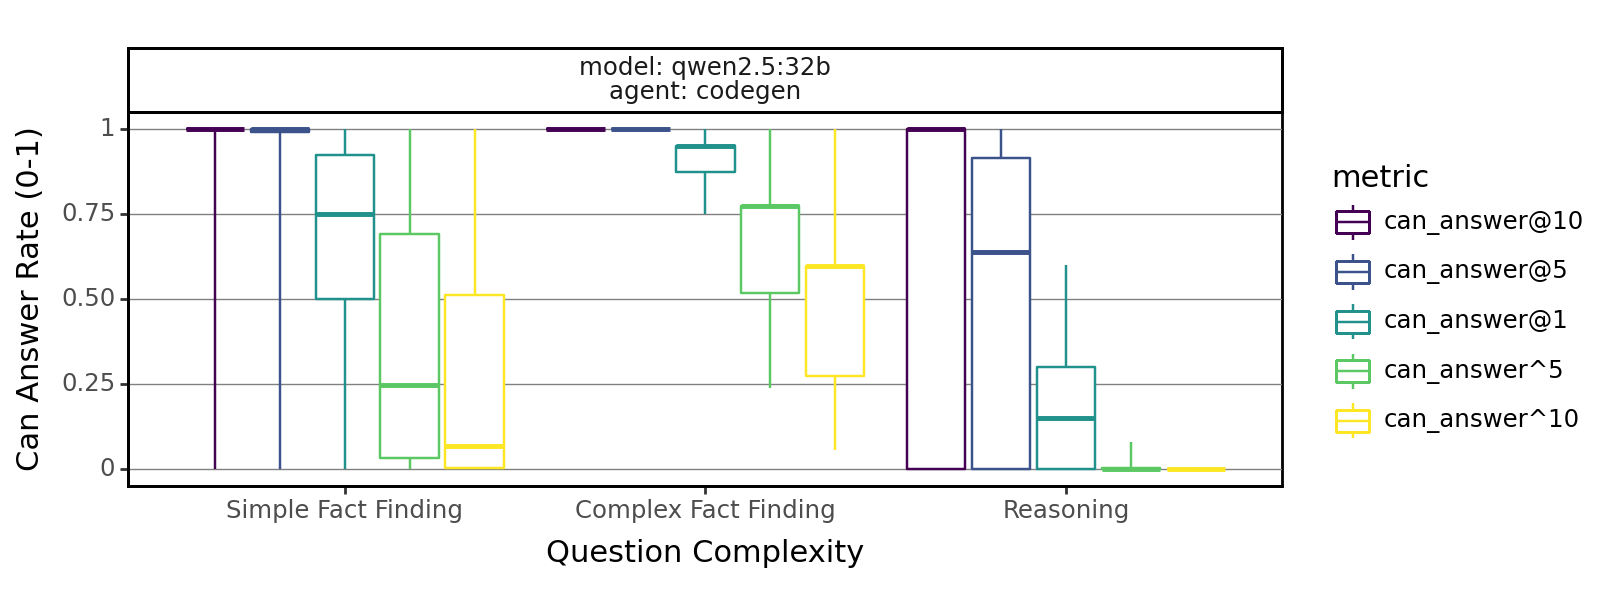

<Figure Size: (800 x 300)>

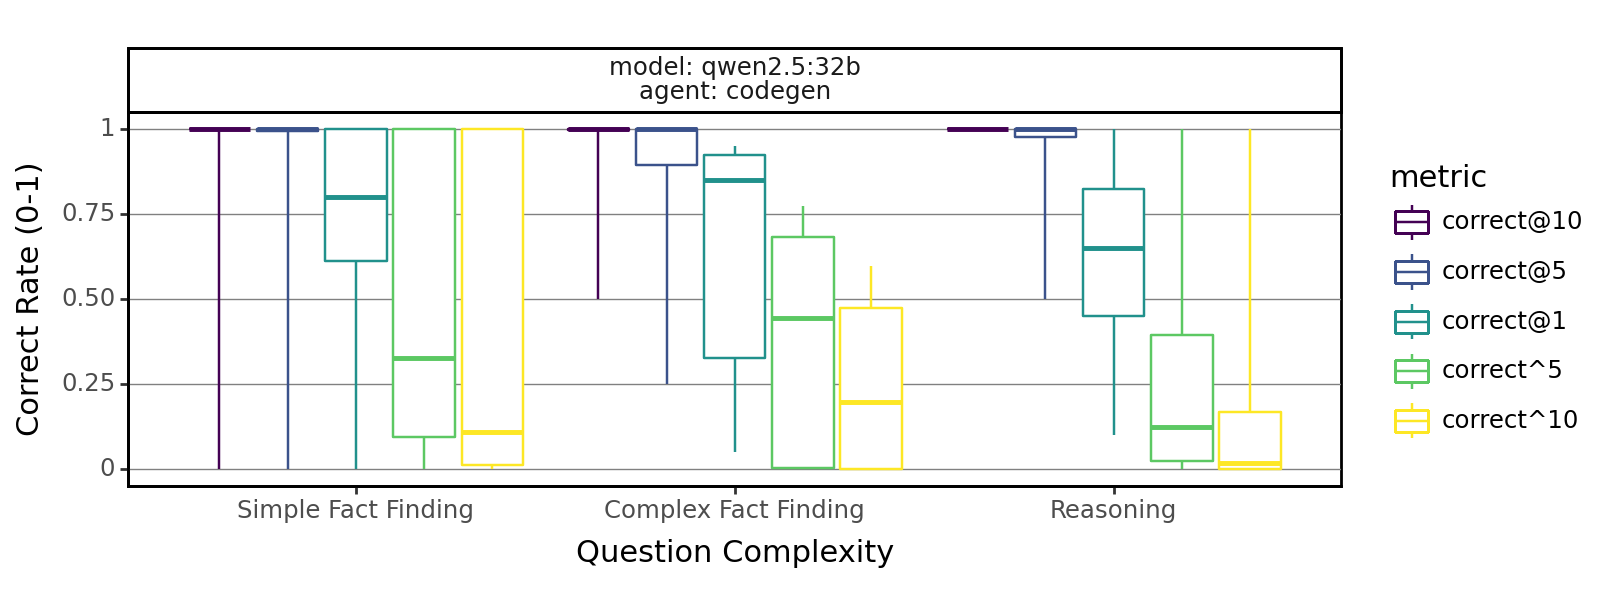

<Figure Size: (800 x 300)>

In [15]:
def draw_metrics(data, metrics, ylabel, x='question_type', xlabel='Question Complexity', width=6, height=3, facet=["model", "agent"], color="metric", logy=False):
    _data = data[data['metric'].isin(metrics)].copy()
    _data["metric"] = pd.Categorical(_data["metric"], categories=metrics, ordered=True)

    p = (
        ggplot(_data)
        + pn.geom_boxplot(
            aes(x=x, ymin="value_min", lower="value_25", middle="value", upper="value_75", ymax="value_max", color=color), 
            position="dodge2", stat = "identity"
        )
        + facet_wrap(facet, labeller="label_both")
        + labs(
            x=xlabel,
            y=ylabel,
            fill="metric",
        )
        + my_theme(width, height)
    )
    if logy:
        p += scale_y_log10()
    return p


_pass_metrics = [
    "pass@10",
    "pass@5",
    "pass@1",
    "pass^5",
    "pass^10",
]
_can_answer_metrics = [
    "can_answer@10",
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
    "can_answer^10",
]
_correct_metrics = [
    "correct@10",
    "correct@5",
    "correct@1",
    "correct^5",
    "correct^10",
]

_g0 = draw_metrics(codegen, _pass_metrics, ylabel="Pass Rate (0-1)", width=8)
_g1 = draw_metrics(codegen, _can_answer_metrics, ylabel="Can Answer Rate (0-1)", width=8)
_g2 = draw_metrics(codegen, _correct_metrics, ylabel="Correct Rate (0-1)", width=8)
display(_g0)
display(_g1)
display(_g2)
_g0.save(f"{OUTPUT_PATH}/question_level_pass.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g1.save(f"{OUTPUT_PATH}/question_level_can_answer.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g2.save(f"{OUTPUT_PATH}/question_level_correct.pdf", bbox_inches="tight", dpi=300, pad_inches=0)


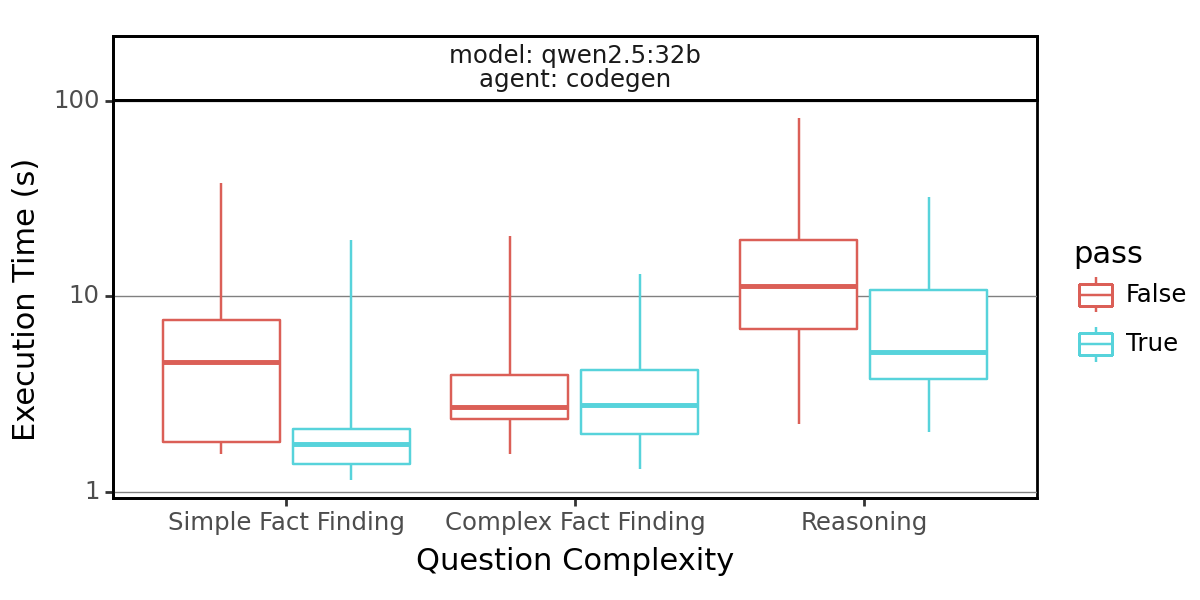

<Figure Size: (600 x 300)>

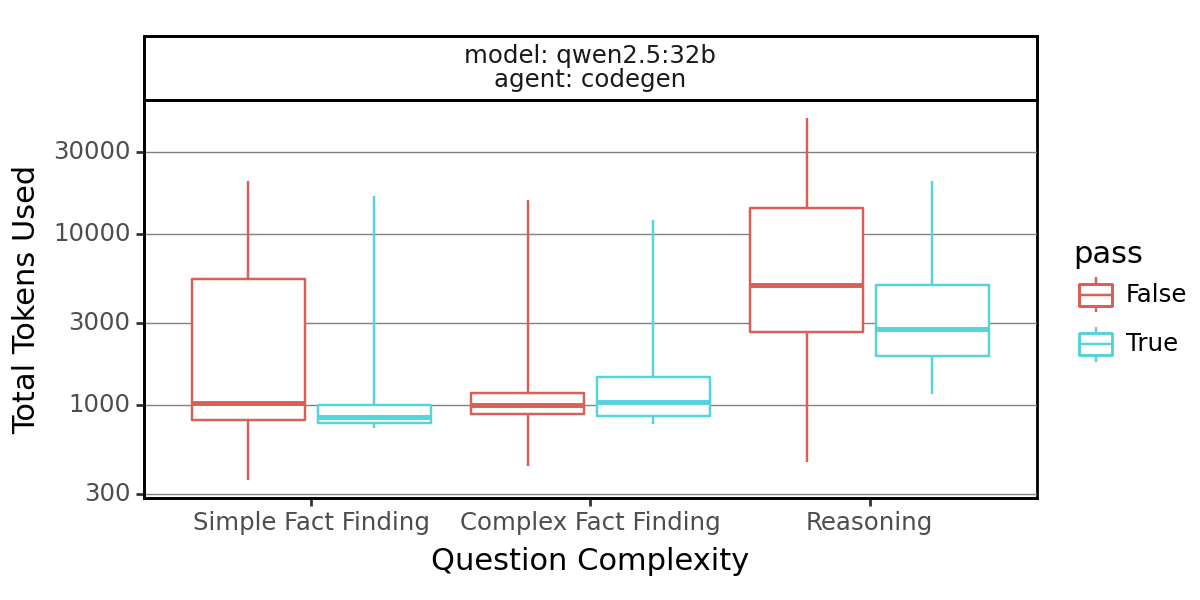

<Figure Size: (600 x 300)>

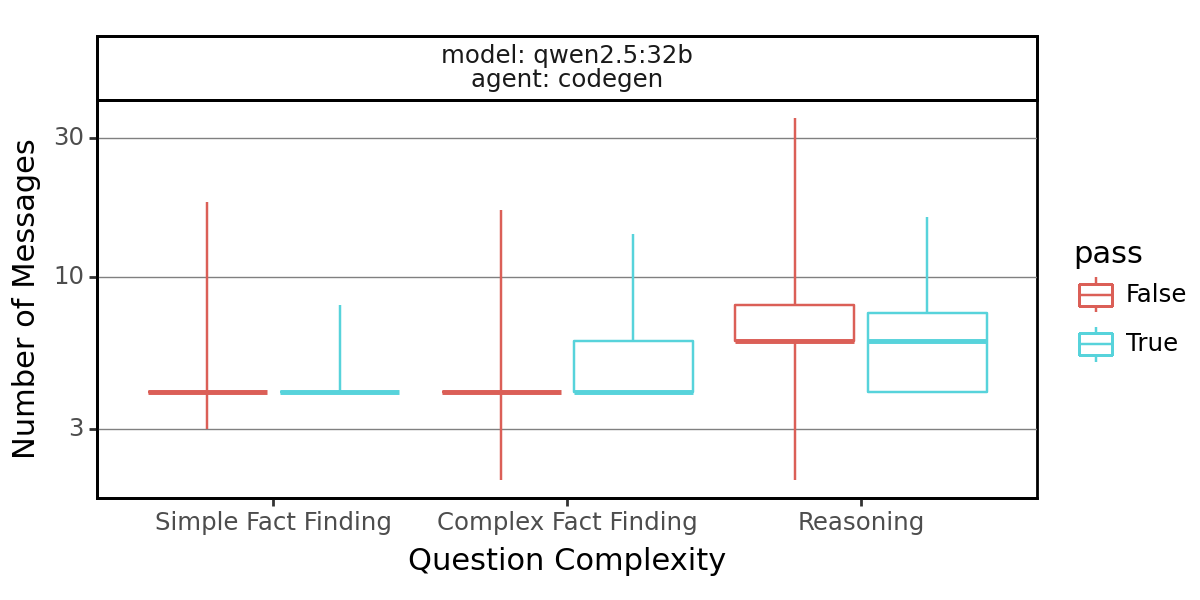

<Figure Size: (600 x 300)>

In [16]:
_cost_groupby = group_by + ['pass']
cost = df[df['agent'] == 'codegen'].melt(
    id_vars=_cost_groupby,
    value_vars=["execution_time", "total_tokens", "num_messages"],
    var_name="metric",
    value_name="value",
).groupby(
    _cost_groupby + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', lambda x: x.quantile(0.5)),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()


_g1 = draw_metrics(cost, ["execution_time"], ylabel="Execution Time (s)", x='question_type', xlabel='Question Complexity', width=6, height=3, facet=["model", "agent"], color="pass", logy=True)
_g2 = draw_metrics(cost, ["num_messages"], ylabel="Number of Messages", x='question_type', xlabel='Question Complexity', width=6, height=3, facet=["model", "agent"], color="pass", logy=True)
_g3 = draw_metrics(cost, ["total_tokens"], ylabel="Total Tokens Used", x='question_type', xlabel='Question Complexity', width=6, height=3, facet=["model", "agent"], color="pass", logy=True)
display(_g1)
display(_g3)
display(_g2)
_g1.save(f"{OUTPUT_PATH}/question_level_execution_time.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g2.save(f"{OUTPUT_PATH}/question_level_num_messages.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g3.save(f"{OUTPUT_PATH}/question_level_total_tokens.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
# _figsize = (12, 3)
# _g = pw.load_ggplot(_g1) + pw.load_ggplot(_g2) + pw.load_ggplot(_g3)
# _g.set_suptitle("Scaling Cost of Qwen-2.5 Models")
# _g.savefig(f"{OUTPUT_PATH}/question_level_cost.png", bbox_inches='tight')

In [18]:
group_by = ["evaluate_as", "model", "agent"]
numerical = df[(df['question_base_format'] == "Numerical") &( df['agent'] == "codegen")]

raw = numerical.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index()
# display(raw)
raw_pivoted = raw.melt(
    id_vars=group_by,
    value_vars=[*agg1.keys()],
    var_name="metric",
    value_name="value",
)
raw_grouped = raw_pivoted.groupby(
    group_by + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', lambda x: x.quantile(0.5)),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()
display(raw_grouped)


,evaluate_as,model,agent,metric,value_min,value_max,value,value_25,value_75
0,Numerical,qwen2.5:32b,codegen,can_answer@1,0.000000e+00,1.000000,0.950000,0.900000,1.000000
1,Numerical,qwen2.5:32b,codegen,can_answer@10,0.000000e+00,1.000000,1.000000,1.000000,1.000000
2,Numerical,qwen2.5:32b,codegen,can_answer@5,0.000000e+00,1.000000,1.000000,1.000000,1.000000
3,Numerical,qwen2.5:32b,codegen,can_answer^10,0.000000e+00,1.000000,0.674339,0.348678,1.000000
4,Numerical,qwen2.5:32b,codegen,can_answer^5,0.000000e+00,1.000000,0.795245,0.590490,1.000000
5,Numerical,qwen2.5:32b,codegen,correct@1,0.000000e+00,1.000000,0.850000,0.350000,0.975000
6,Numerical,qwen2.5:32b,codegen,correct@10,0.000000e+00,1.000000,1.000000,1.000000,1.000000
7,Numerical,qwen2.5:32b,codegen,correct@5,0.000000e+00,1.000000,1.000000,0.936508,1.000000
8,Numerical,qwen2.5:32b,codegen,correct^10,0.000000e+00,1.000000,0.228026,0.000249,0.837170
9,Numerical,qwen2.5:32b,codegen,correct^5,0.000000e+00,1.000000,0.459085,0.009635,0.897622


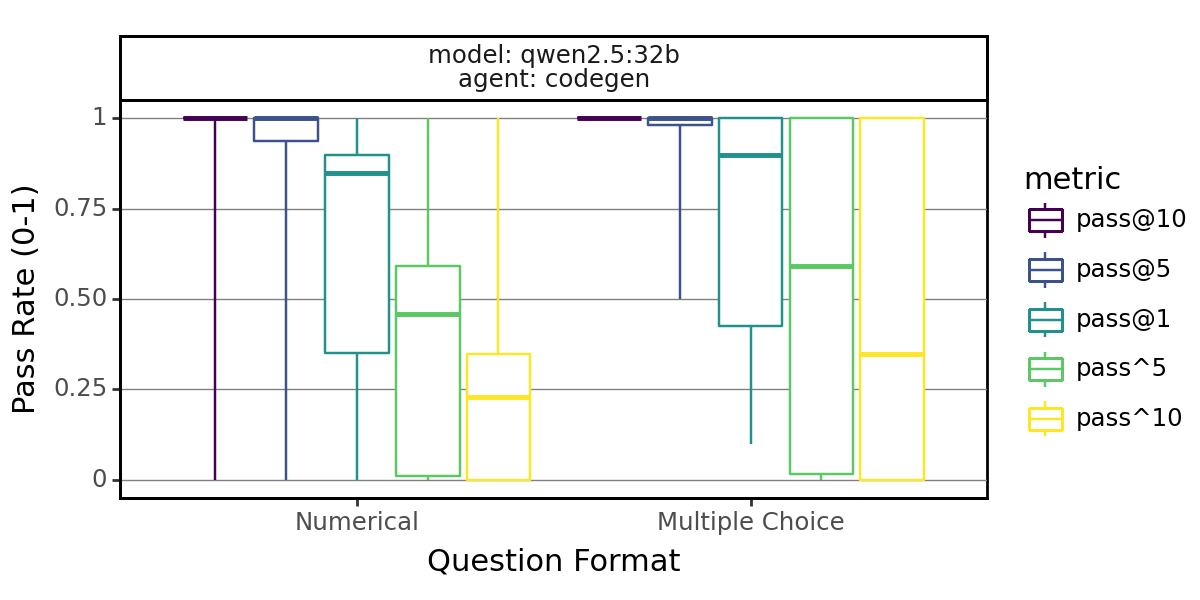

<Figure Size: (600 x 300)>

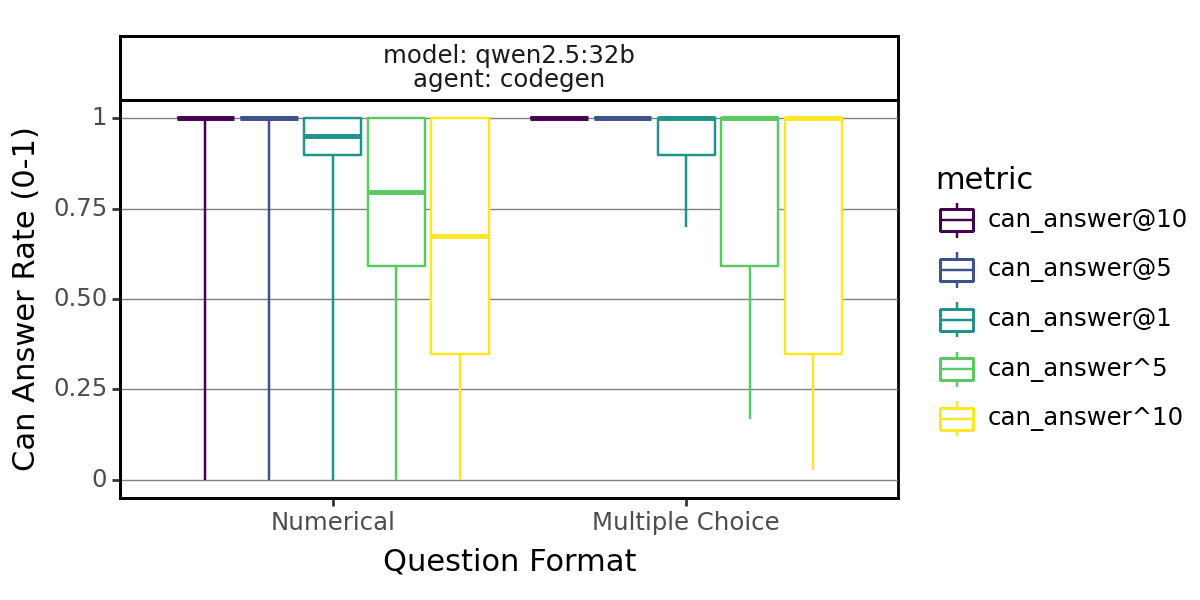

<Figure Size: (600 x 300)>

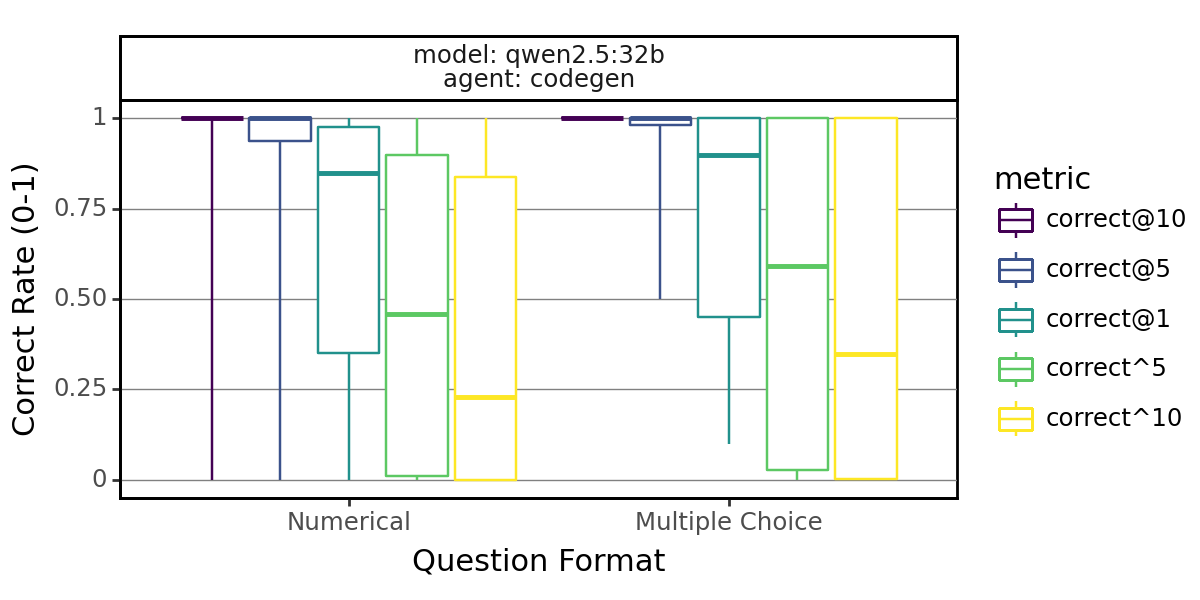

<Figure Size: (600 x 300)>

In [21]:
_pass_metrics = [
    "pass@10",
    "pass@5",
    "pass@1",
    "pass^5",
    "pass^10",
]
_can_answer_metrics = [
    "can_answer@10",
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
    "can_answer^10",
]
_correct_metrics = [
    "correct@10",
    "correct@5",
    "correct@1",
    "correct^5",
    "correct^10",
]

_g0 = draw_metrics(raw_grouped, _pass_metrics, ylabel="Pass Rate (0-1)", x='evaluate_as', xlabel='Question Format')
_g1 = draw_metrics(raw_grouped, _can_answer_metrics, ylabel="Can Answer Rate (0-1)", x='evaluate_as', xlabel='Question Format')
_g2 = draw_metrics(raw_grouped, _correct_metrics, ylabel="Correct Rate (0-1)", x='evaluate_as', xlabel='Question Format')
display(_g0)
display(_g1)
display(_g2)

_g0.save(f"{OUTPUT_PATH}/question_form_pass.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g1.save(f"{OUTPUT_PATH}/question_form_can_answer.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g2.save(f"{OUTPUT_PATH}/question_form_correct.pdf", bbox_inches="tight", dpi=300, pad_inches=0)


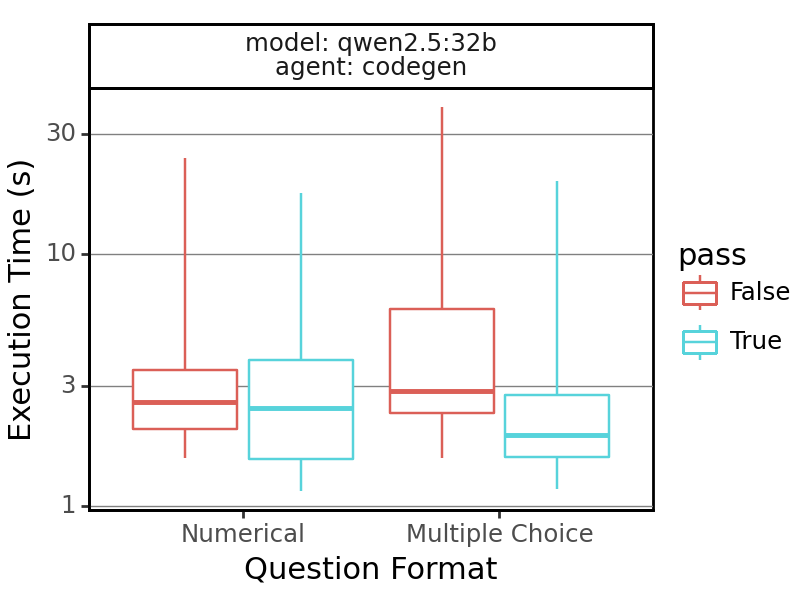

<Figure Size: (400 x 300)>

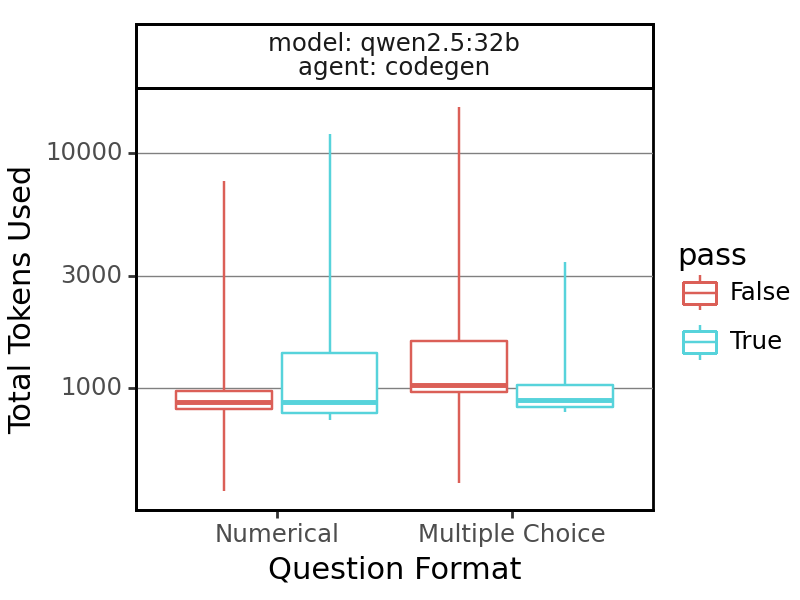

<Figure Size: (400 x 300)>

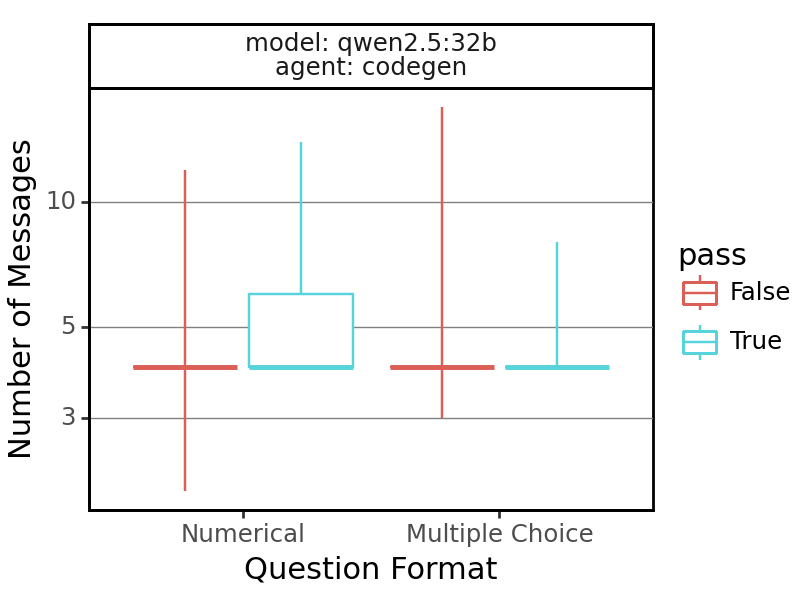

<Figure Size: (400 x 300)>

In [20]:
_cost_groupby = group_by + ['pass']
_cost = numerical.melt(
    id_vars=_cost_groupby,
    value_vars=["execution_time", "total_tokens", "num_messages"],
    var_name="metric",
    value_name="value",
).groupby(
    _cost_groupby + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', lambda x: x.quantile(0.5)),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()

_g1 = draw_metrics(_cost, ["execution_time"], ylabel="Execution Time (s)", x='evaluate_as', xlabel='Question Format', width=4, height=3, facet=["model", "agent"], color="pass", logy=True)
_g2 = draw_metrics(_cost, ["num_messages"], ylabel="Number of Messages", x='evaluate_as', xlabel='Question Format', width=4, height=3, facet=["model", "agent"], color="pass", logy=True)
_g3 = draw_metrics(_cost, ["total_tokens"], ylabel="Total Tokens Used", x='evaluate_as', xlabel='Question Format', width=4, height=3, facet=["model", "agent"], color="pass", logy=True)
display(_g1)
display(_g3)
display(_g2)

_g1.save(f"{OUTPUT_PATH}/question_form_execution_time.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g2.save(f"{OUTPUT_PATH}/question_form_num_messages.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
_g3.save(f"{OUTPUT_PATH}/question_form_total_tokens.pdf", bbox_inches="tight", dpi=300, pad_inches=0)


In [ ]:
def get_table(scenario):
    q_examples = pd.DataFrame([
        {
            "scenario": test_case.scenario or "base",
            "question": question.question,
            "question_type": levels[question.level],
            "question_base_format": evaluate_as[question.base_type],
        }
        for test_case in TEST_CASES
        for question in test_case.questions
    ])
    q_examples['question_type'] = pd.Categorical(q_examples['question_type'], categories=levels, ordered=True)
    q_examples['question_base_format'] = pd.Categorical(q_examples['question_base_format'], categories=evaluate_as, ordered=True)
    q_examples = q_examples[q_examples['scenario'] == scenario]
    q_examples['question'] = q_examples['question'].str.replace("`None`", "`{FAILING_POD_NAME}").str.replace("`productcatalogservice`", "`{FAILING_DEPLOYMENT_NAME}`")
    q_examples = q_examples.sort_values(by=['scenario', 'question_type', "question_base_format"])
    q_examples = q_examples[["question_type", "question_base_format", "question"]].rename(
        columns={
            "question": "Question",
            "question_type": "Question Type",
            "question_base_format": "Question Base Format",
        }
    )
    return q_examples

q_image_not_found = get_table('image-not-found')
display(q_image_not_found)
# q_image_not_found.to_latex(
#     f"{OUTPUT_PATH}/table_question_image_not_found.tex",
#     index=False,
#     escape=True,
#     column_format="@{}p{0.15\linewidth}p{0.15\linewidth}p{0.6\linewidth}@{}",
#     label="tab:question_examples_image_not_found",
#     caption="Scenario: Image Not Found. Example Questions and their Types and Formats",
#     multirow=True,
#     multicolumn=True,
#     position="h"
# )

q_resource_constraint = get_table('resource-constraint')
display(q_resource_constraint)
# q_resource_constraint.to_latex(
#     f"{OUTPUT_PATH}/table_question_resource_constraint.tex",
#     index=False,
#     escape=True,
#     column_format="@{}p{0.15\linewidth}p{0.15\linewidth}p{0.6\linewidth}@{}",
#     label="tab:question_examples_resource_constraint",
#     caption="Scenario: Resource Constraint. Example Questions and their Types and Formats",
#     multirow=True,
#     multicolumn=True,
#     position="h"
# )

,Question Type,Question Base Format,Question
22,Simple Fact Finding,Multiple Choice,Which container in pod `{FAILING_POD_NAME} is ...
23,Simple Fact Finding,Multiple Choice,Which pod in deployment `{FAILING_DEPLOYMENT_N...
21,Complex Fact Finding,Numerical,How many pods in deployment `{FAILING_DEPLOYME...
24,Reasoning,Multiple Choice,Why is pod `{FAILING_POD_NAME} unhealthy?
25,Reasoning,Multiple Choice,Why is deployment `{FAILING_DEPLOYMENT_NAME}` ...
26,Reasoning,Multiple Choice,Why is deployment `{FAILING_DEPLOYMENT_NAME}` ...
27,Reasoning,Multiple Choice,How to fix pod `{FAILING_POD_NAME} being unhea...
28,Reasoning,Multiple Choice,How to fix deployment `{FAILING_DEPLOYMENT_NAM...


,Question Type,Question Base Format,Question
13,Simple Fact Finding,Numerical,What is the total memory requested by pod `{FA...
14,Simple Fact Finding,Multiple Choice,Which pod is pending for deployment `{FAILING_...
12,Complex Fact Finding,Numerical,How many pods are pending for deployment `{FAI...
15,Complex Fact Finding,Numerical,What is the total memory requested by pending ...
16,Reasoning,Multiple Choice,Why is pod `{FAILING_POD_NAME} pending?
17,Reasoning,Multiple Choice,Why is deployment `{FAILING_DEPLOYMENT_NAME}` ...
18,Reasoning,Multiple Choice,Why is deployment `{FAILING_DEPLOYMENT_NAME}` ...
19,Reasoning,Multiple Choice,How to fix pod `{FAILING_POD_NAME} being pending?
20,Reasoning,Multiple Choice,How to fix deployment `{FAILING_DEPLOYMENT_NAM...
